# Notebook supporting the manuscript: "*pyet* - A python tool for estimating potential evaporation and accounting for model uncertainty and climate change"
*M.Vremec, October 2022, University of Graz*

*R.Collenteur, eawag, Switzerland*

Data source: ZAMG - https://data.hub.zamg.ac.at

### The supporting Notebook is structured as follows:

1. PE assessment using a variety of different methods (with station data KNMI)
    - Makkink vs PM vs Oudin vs Priestley-Taylor vs Hamon vs Hargreaves
2. PE calibration and spatial application (with eobs data)
    - calculate_all
3. Estimating PE under climate change  (with ZAMG data)
    - uncalibrated
    - calibrated on Ambient
    - calibrated on future

## Import packages

In [1]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import seaborn as sns

from scipy.optimize import least_squares
import pylab
import matplotlib.dates as mdates

import pyet
from utils import *
pyet.show_versions()

Python version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Pandas version: 1.4.4
Pyet version: 1.2.0b


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# edit default values for plots
params = {
    "font.family": "Arial",
    "legend.fontsize": "15",
    "axes.labelsize": "16",
    "xtick.labelsize": "14",
    "ytick.labelsize": "14",
    "xtick.direction": "in",
    "ytick.direction": "in",}
pylab.rcParams.update(params)

# 1. PE estimation using station data.

Potential evaporation is estimated for the town of De Bilt (Netherlands) using data provided by the Royal Netherlands Meteorological Institute (KNMI). The KNMI reference method for estimating potential evaporation is the Makkink method. The example shows PE estimation with \textit{pyet} using 18 different PE methods, a visual comparison between daily, monthly and cumulative PE, and a comparison between the Makkink's PE estimated with \textit{pyet} and Makkink's PE estimated by the KNMI.

Data source: KNMI - https://dataplatform.knmi.nl/

In [4]:
# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [5]:
# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

Now that we have defined the input data, we can estimate potential evaporation with different estimation methods. 

In [6]:
# 4. Estimate potential evaporation (with all available methods) and save the results in a Pandas.DataFrame
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

In [7]:
print((pet_df.sum().max()-pet_df.sum().mean())/pet_df.sum().mean()*100)
print((pet_df.sum().min()-pet_df.sum().mean())/pet_df.sum().mean()*100)

35.154078442084966
-16.613853456666426


We plot the daily, monthly and cumulative sums to compare the different estimation methods, and also benchmark the Makkink bethod to the KNMI estimated PE with Makkink.

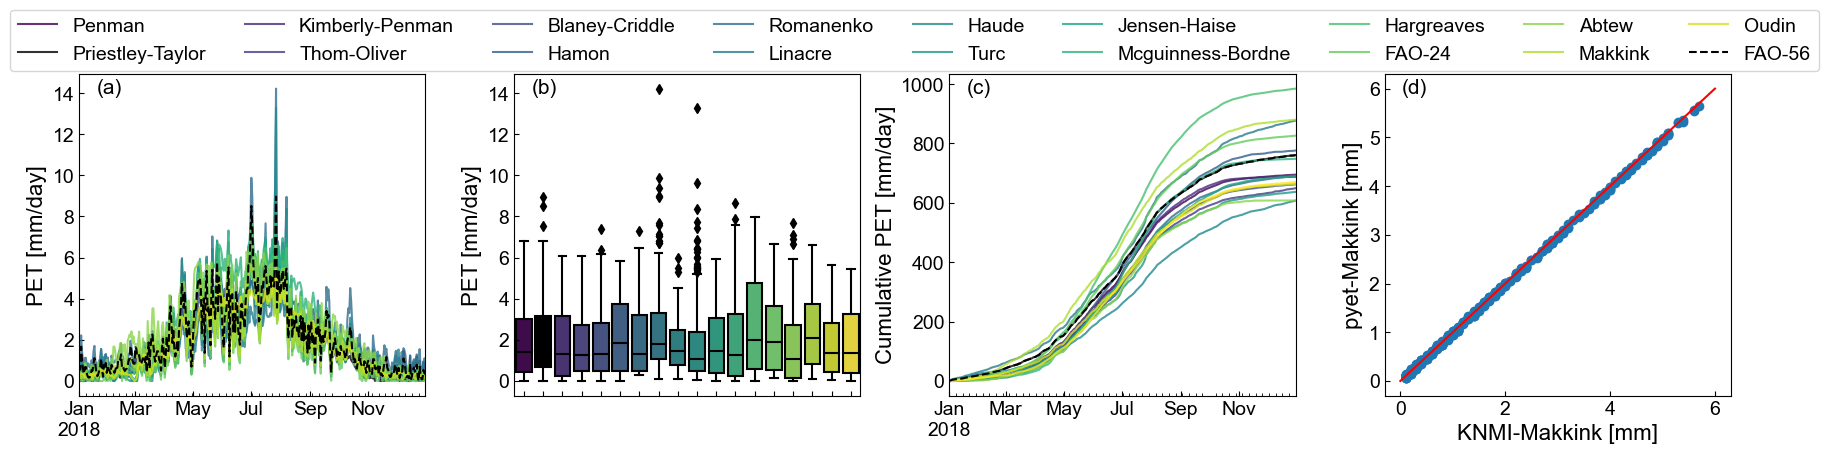

In [8]:
viridis = cm.get_cmap('viridis', len(pet_df.columns))
colors = [viridis(i) for i in range(0, len(pet_df.columns))]
colors[1] = "k"
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns

fig, axs = plt.subplots(figsize=(figw_2c, 4), ncols=4)

pet_df.loc[:, pet_df.columns != "FAO-56"].plot(color=colors, legend=False, ax=axs[0], alpha=0.8)
pet_df.loc[:, "FAO-56"].plot(color=colors[1], linestyle="--", legend=False, ax=axs[0])
axs[0].set_ylabel("PET [mm/day]")

sns.boxplot(pet_df, ax=axs[1], palette=colors)
axs[1].set_ylabel("PET [mm/day]")

pet_df.cumsum().plot(color=colors, legend=False, ax=axs[2], alpha=0.8)
pet_df.loc[:, "FAO-56"].cumsum().plot(color=colors[1], linestyle="--", legend=False, ax=axs[2])
axs[2].set_ylabel("Cumulative PET [mm/day]")

axs[3].scatter(pet_knmi, pet_df["Makkink"])
axs[3].plot([0,6],[0,6], color="red", label="1:1 line")
axs[3].set_xlabel("KNMI-Makkink [mm]");
axs[3].set_ylabel("pyet-Makkink [mm]")

for i in (0,2):
    axs[i].set(xlabel=None)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

axs[1].set_xticklabels([])
plt.tight_layout()
axs[0].legend(loc=(-0.2,1.01), ncol=9, bbox_transform=axs[0].transAxes, fontsize=14)
axs[0].text(0.05,0.94, "(a)", transform=axs[0].transAxes, fontsize=15)
axs[1].text(0.05,0.94, "(b)", transform=axs[1].transAxes, fontsize=15)
axs[2].text(0.05,0.94, "(c)", transform=axs[2].transAxes, fontsize=15)
axs[3].text(0.05,0.94, "(d)", transform=axs[3].transAxes, fontsize=15)
fig.savefig("figure1.png", dpi=600, bbox_inches="tight")

# 2. Estimate PE for gridded data

In [9]:
# import E-OBS
wind = xr.open_dataset("data//example_0//fg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4")["fg"]
tmax = xr.open_dataset("data//example_0//tx_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tx"]
tmin = xr.open_dataset("data//example_0//tn_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                       engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                             latitude=slice(wind.latitude.min(), wind.latitude.max()))["tn"]
tmean = xr.open_dataset("data//example_0//tg_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                        engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                              latitude=slice(wind.latitude.min(), wind.latitude.max()))["tg"]

In [10]:
rs = xr.open_dataset("data//example_0//qq_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rs = rs.rename_dims({"lon":"longitude", "lat":"latitude"}).rename({"lon":"longitude", "lat":"latitude"}).sel(ensemble=10)["qq"] * 86400 / 1000000

In [11]:
rh = xr.open_dataset("data//example_0//hu_ens_mean_0.25deg_reg_2018_v25.0e.nc", 
                     engine="netcdf4").sel(lon=slice(wind.longitude.min(), wind.longitude.max()), 
                                           lat=slice(wind.latitude.min(), wind.latitude.max()))
rh = rh.rename_dims({"lon":"longitude", "lat":"latitude"}).rename({"lon":"longitude", "lat":"latitude"})["hu"]

In [12]:
elevation =  xr.open_dataset("data//example_0//elev_ens_0.25deg_reg_v25.0e.nc", 
                     engine="netcdf4").sel(longitude=slice(wind.longitude.min(), wind.longitude.max()), 
                                           latitude=slice(wind.latitude.min(), wind.latitude.max()))["elevation"].fillna(0)

lat = tmean.latitude * np.pi / 180
lat = lat.expand_dims(dim={"longitude":tmean.longitude}, axis=1)

In [13]:
pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
makkink = pyet.makkink(tmean, rs, elevation=elevation)
hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)

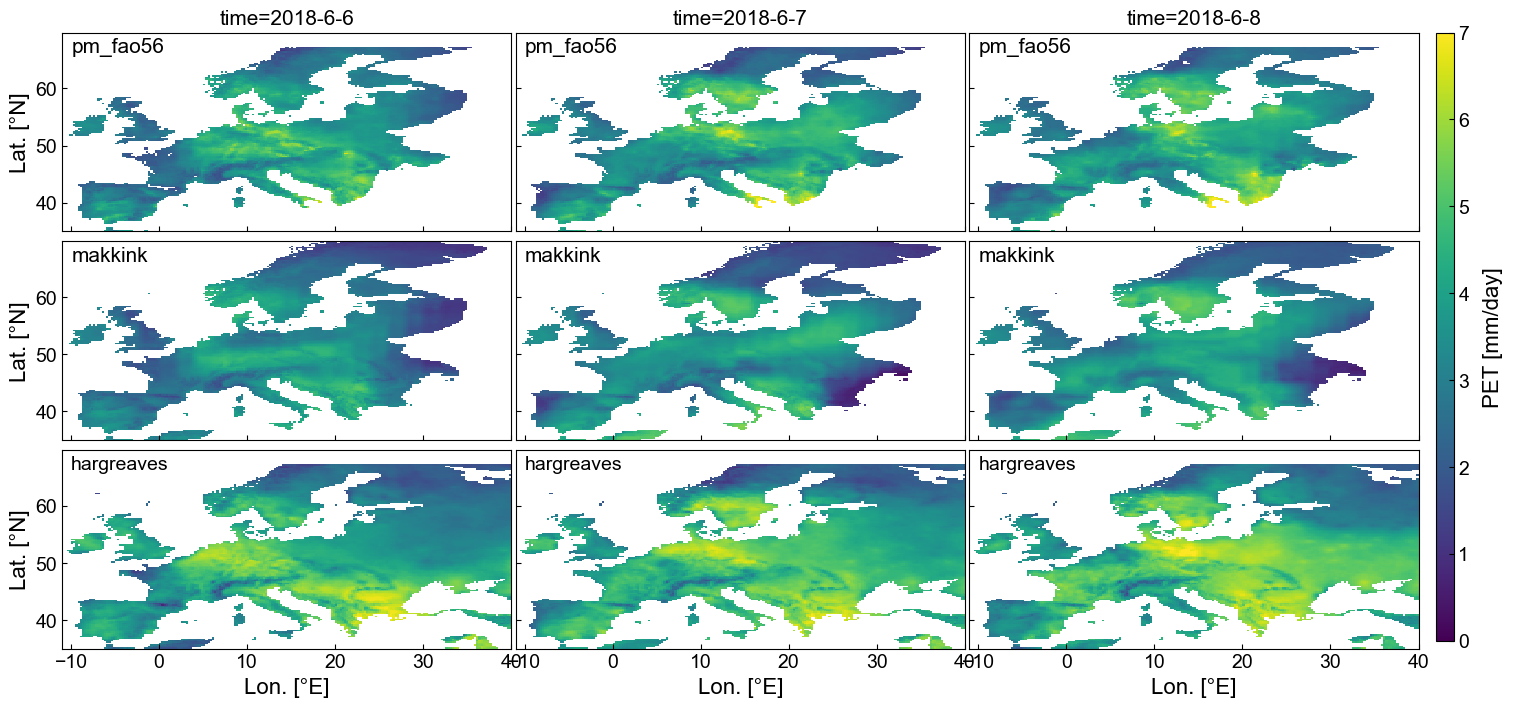

In [14]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
vmax = 7
vmin = 0
day = 120
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(figw_2c, 8), sharey=True, sharex=True)

for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
    pm_fao56.sel(time=date).plot(ax=axs[0,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[0,i].text(0.02, 0.9, "pm_fao56", transform=axs[0,i].transAxes, fontsize=15)

    makkink.sel(time=date).plot(ax=axs[1,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[1,i].text(0.02, 0.9, "makkink", transform=axs[1,i].transAxes, fontsize=15)

    im = hargreaves.sel(time=date).plot(ax=axs[2,i],vmax=vmax, vmin=vmin, add_colorbar=False)
    axs[2,i].text(0.02, 0.9, "hargreaves", transform=axs[2,i].transAxes, fontsize=14)
    

for date, i in zip(["2018-6-6", "2018-6-7", "2018-6-8"],[0,1,2]):
    for j in (0,1,2):
        axs[i, j].set_ylabel("")
        axs[i, j].set_xlabel("")
        axs[i, j].set_title("")
        axs[2,j].set_xlabel("Lon. [°E]")
    axs[i, 0].set_ylabel("Lat. [°N]")
    axs[0,i].set_title("time="+date, fontsize=15)

cbar_ax = fig.add_axes([0.91, 0.12, 0.01, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("PET [mm/day]", labelpad=10)
plt.subplots_adjust(hspace=0.05, wspace=0.01)
fig.savefig("figure2.png", dpi=600, bbox_inches="tight")

# 2. PE calibration and hind/forecasting

In [15]:
#read station data
data_16412 = pd.read_csv('data//example_1//klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


In [16]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100
meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

# Estimate evaporation with four different methods and create a dataframe
pe_df = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax=tmax,
                                tmin=tmin, rh=rh)

## 2.1 Calibrate alternative PE methods to Penman-Monteith

In [17]:
methods = ["oudin", "hargreaves", "mcguinness_bordne", 
           "hamon", "blaney_criddle"]

# Define initial values for calibration for each method
params = [[100, 5], [0.0135], [0.0147],
         [1], [-1.55, 0.96]]

# Define input for each method
input2 = ([tmean, lat], [tmean, tmax, tmin, lat], [tmean, lat],
         [tmean, lat], [tmean, lat])

# Define function to estimate residuals
def simulate(params, method, input1):   
    input1_1 = input1.copy()
    method = getattr(pyet, method)
    for par in params:
        input1_1.append(par)
    return method(*input1_1)
    
def residuals(params, info):
    method, input1, obs = info
    sim = simulate(params, method, input1)
    return sim - obs

In [18]:
obs = pe_df["FAO-56"]
sollutions2 = []
for i in np.arange(0,len(methods)):
    res_1 = least_squares(residuals, params[i], args=[[methods[i], input2[i], obs]])
    sollutions2.append(res_1.x)

In [19]:
pe_df_def = pd.DataFrame()
pe_df_cali = pd.DataFrame()
for i in np.arange(0, len(methods)):
    pe_df_def[methods[i]] = simulate(params[i], methods[i], input2[i])
    pe_df_cali[methods[i]] = simulate(sollutions2[i], methods[i], input2[i])

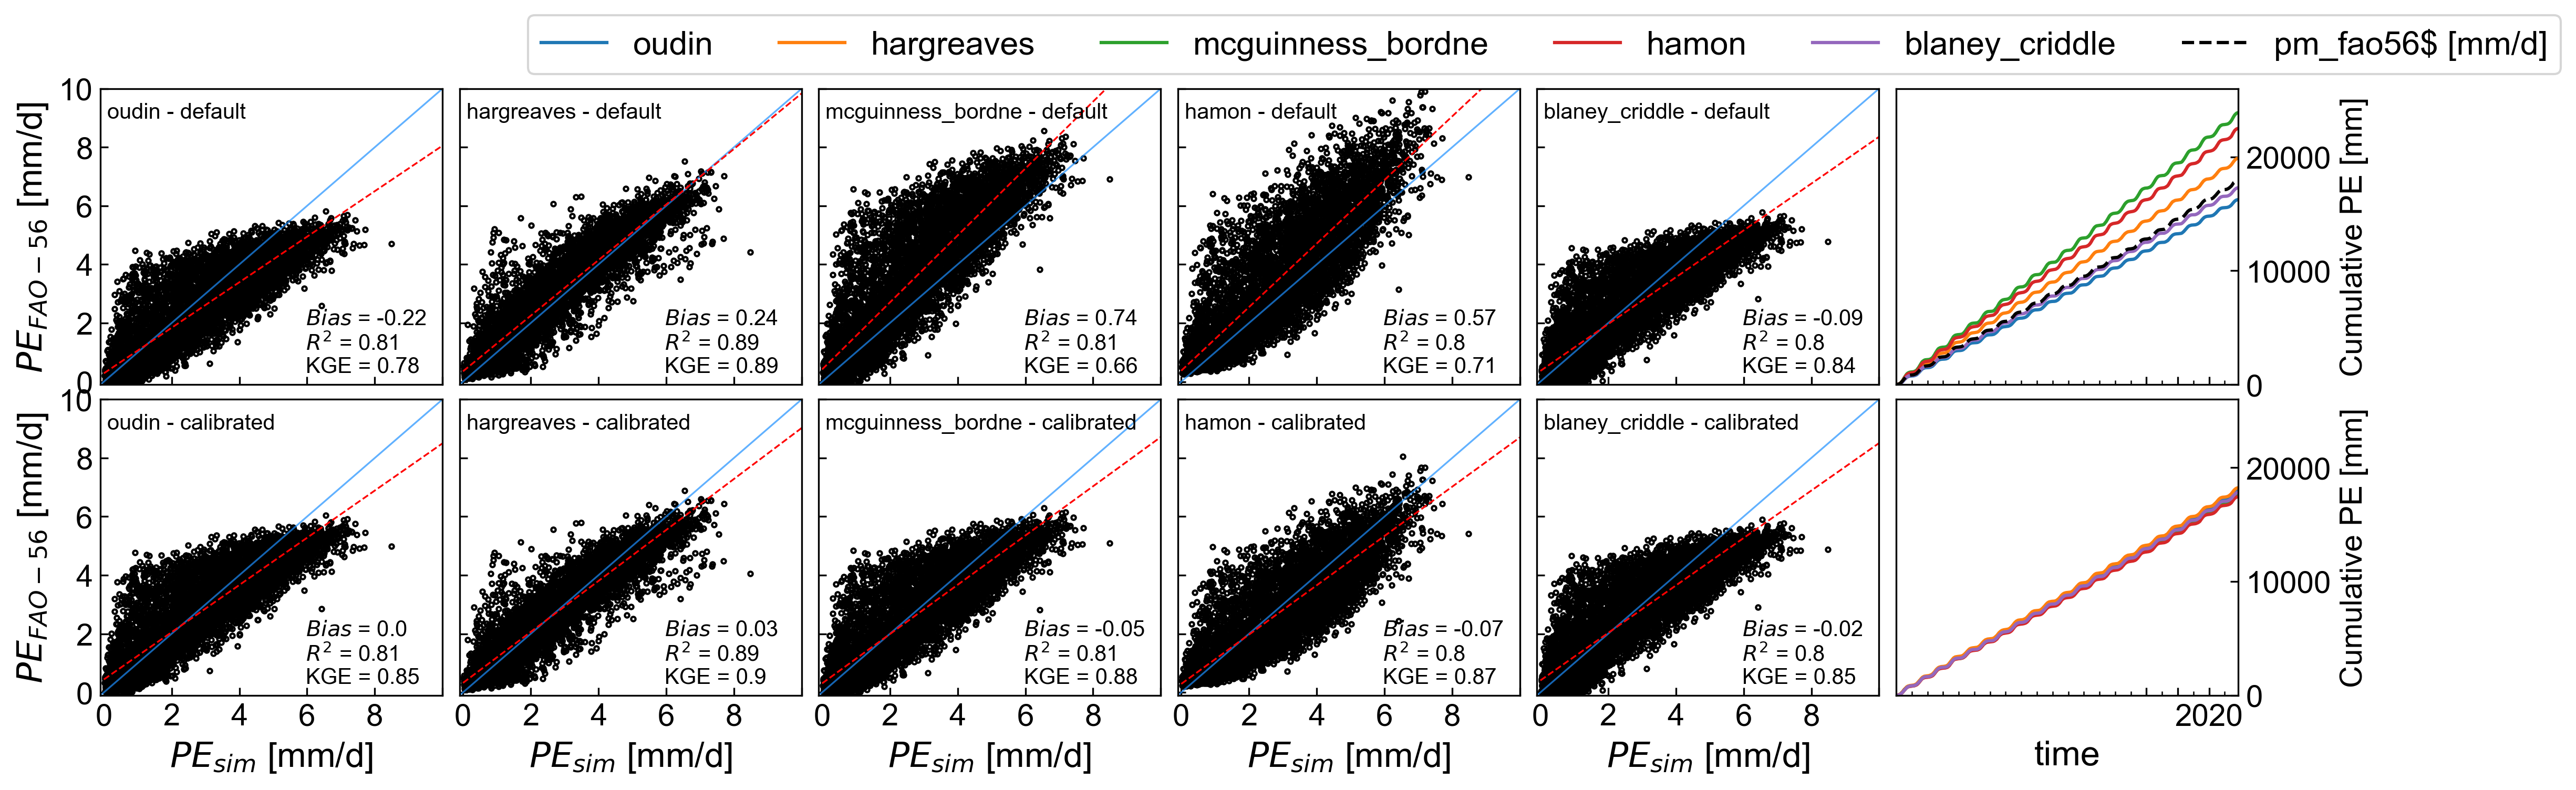

In [20]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns

fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(figw_2c, 5), dpi=300)
for i in np.arange(0, len(methods)):
    axs[0,i] = scatter_1(axs[0,i], obs, simulate(params[i], methods[i], input2[i]), label=f"{methods[i]} - default")
    axs[1,i] = scatter_1(axs[1,i], obs, simulate(sollutions2[i], methods[i], input2[i]), label=f"{methods[i]} - calibrated")
    axs[0, i].set_xticklabels([])
    axs[1, i].set_xlabel(r"$PE_{sim}$ [mm/d]")
    axs[1, i].set_xticklabels((0,2,4,6,8,""))
for col in (1, 2, 3, 4):
    axs[0, col].set_yticklabels([])
    axs[1, col].set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for row in (0, 1):
    axs[row, 0].set_ylabel(r"$PE_{FAO-56}$ [mm/d]")
pe_df_def.cumsum().plot(ax=axs[0, 5], legend=False)
obs.cumsum().plot(ax=axs[0,5], label="pm_fao56$ [mm/d]", color="k", linestyle="--", )
obs.cumsum().plot(ax=axs[1,5], label="pm_fao56", color="k", linestyle="--", )
pe_df_cali.cumsum().plot(ax=axs[1, 5], legend=False)
for i in (0,1):
    axs[i,5].yaxis.tick_right()
    axs[i,5].yaxis.set_label_position("right")
    axs[i,5].set_xticks((pd.Timestamp("2016-1-1"), pd.Timestamp("2018-1-1"), pd.Timestamp("2020-1-1")))
    axs[i,5].set_ylim(0,26000)
    axs[i,5].set_ylabel("Cumulative PE [mm]", fontsize=14)
axs[0,5].set_xticklabels("");
axs[0,5].set_xlabel("");
plt.subplots_adjust(hspace=0.05, wspace=0.05)
axs[0,5].legend(loc=(-4,1.05), ncol=7, bbox_transform=axs[1,5].transAxes)
#fig.savefig("figure3.png", dpi=600, bbox_inches="tight")

## 2.2 Hindcasting PE for Graz, Austria

In [21]:
# Estimate for Grazer feld and define input meteorological variables
spartacus = xr.open_dataset("data//example_0//spartacus-daily_19610101T0000_20211231T0000.nc", engine="netcdf4")
spartacus_cali = spartacus.copy()

In [22]:
# Define new input
tmean_spartacus = (spartacus["Tx"] + spartacus["Tn"]) / 2
tmax_spartacus = spartacus["Tx"]
tmin_spartacus = spartacus["Tn"]
lat_spartacus = spartacus.lat * np.pi / 180  # from degrees to radians
input_spartacus = ([tmean_spartacus, lat_spartacus], [tmean_spartacus, tmax_spartacus, tmin_spartacus, lat_spartacus], [tmean_spartacus, lat_spartacus],
         [tmean_spartacus, lat_spartacus], [tmean_spartacus, lat_spartacus])

In [23]:
# Compute PE for Gumpenstein area and add to initial xarray 
for i in np.arange(0,len(methods)):
    spartacus[methods[i]] = simulate(params[i], methods[i], input_spartacus[i])
    spartacus_cali[methods[i]] = simulate(sollutions2[i], methods[i], input_spartacus[i])

In [24]:
df_def = spartacus.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])
df_cali = spartacus_cali.to_dataframe().reset_index(level=[1,1]).drop(columns=["y", "Tn", "Tx", "lambert_conformal_conic", "lon", "lat"])

Text(0.02, 0.93, '(f)')

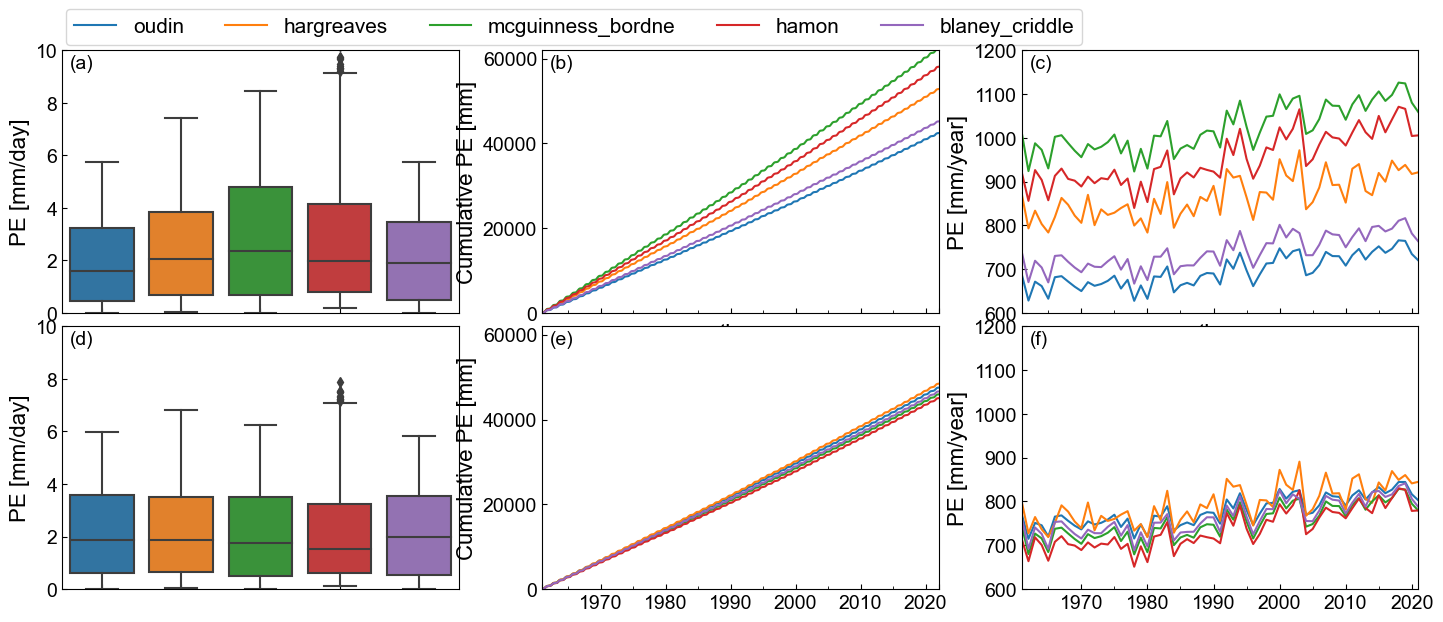

In [25]:
import seaborn as sns
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
vmax = 3.3
vmin = 1.5
day = 120
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(figw_2c,7))
sns.boxplot(data=df_def, ax=axs[0,0])
sns.boxplot(data=df_cali, ax=axs[1,0])
df_def.cumsum().plot(ax=axs[0,1], legend=False)
df_cali.cumsum().plot(ax=axs[1,1], legend=False)

df_def.resample("y").sum().plot(ax=axs[0,2], legend=False)
df_cali.resample("y").sum().plot(ax=axs[1,2], legend=False)

for i in (0,1):
    axs[i,0].set_ylim(0, 10)
    axs[i,0].set_xticklabels("")
    axs[i,1].set_ylim(0, 62000)
    axs[i,2].set_ylim(600, 1200)
    axs[i,0].set_ylabel("PE [mm/day]")
    axs[i,1].set_ylabel("Cumulative PE [mm]")
    axs[i,2].set_ylabel("PE [mm/year]")
axs[0,1].set_xticklabels("")
axs[0,2].set_xticklabels("")
axs[1,1].set_xlabel("")
axs[1,2].set_xlabel("")
axs[0,1].legend(loc=(-1.2,1.02), ncol=5, bbox_transform=axs[1,0].transAxes)
plt.subplots_adjust(hspace=0.05, wspace=0.21)
axs[0,0].text(0.02,0.93, "(a)", transform=axs[0,0].transAxes, fontsize=14)
axs[0,1].text(0.02,0.93, "(b)", transform=axs[0,1].transAxes, fontsize=14)
axs[0,2].text(0.02,0.93, "(c)", transform=axs[0,2].transAxes, fontsize=14)
axs[1,0].text(0.02,0.93, "(d)", transform=axs[1,0].transAxes, fontsize=14)
axs[1,1].text(0.02,0.93, "(e)", transform=axs[1,1].transAxes, fontsize=14)
axs[1,2].text(0.02,0.93, "(f)", transform=axs[1,2].transAxes, fontsize=14)
#fig.savefig("figure4.png", dpi=600, bbox_inches="tight")

# 2.3 Forecasting for Graz Austria

$$ PET_{CO_2} = f_{CO_2} PET $$

In [26]:
# RCP scenario 4.5
tincrease = 2.2
co2 = 570
co2_amb = 400

pe_300 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh)
pe_co2 = pyet.pm(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                 tmax=tmax, tmin=tmin, rh=rh, co2=co2)
pe_rcp45 = pyet.pm(tmean+tincrease, wind, rs=rs, elevation=elevation, lat=lat, 
                    tmax=tmax+tincrease, tmin=tmin+tincrease, rh=rh, co2=co2)
pe_tincrease = pyet.pm(tmean+tincrease, wind, rs=rs, elevation=elevation, lat=lat, 
                    tmax=tmax+tincrease, tmin=tmin+tincrease, rh=rh)

<AxesSubplot:xlabel='time'>

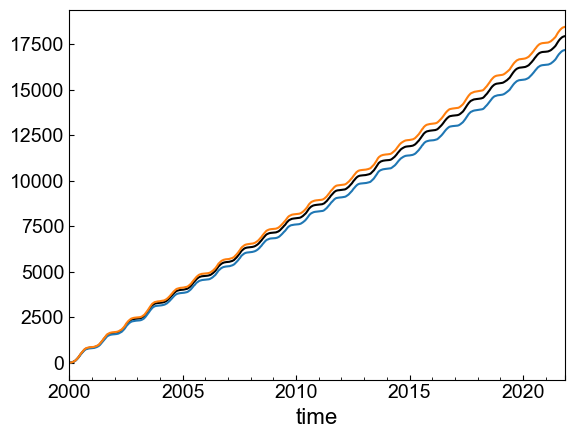

In [27]:
pe_300.cumsum().plot(color="k")
pe_co2.cumsum().plot()
pe_rcp45.cumsum().plot()

In [28]:
# Define input for each method
input3 = ([tmean+tincrease, lat], [tmean+tincrease, tmax+tincrease, tmin+tincrease, lat], [tmean+tincrease, lat],
         [tmean+tincrease, lat], [tmean+tincrease, lat])

In [29]:
def residuals_co2(S_CO2, PETco2, PETamb):
    fco2 = (1+S_CO2*(co2-300))
    return PETco2 - PETamb * fco2
res1 = least_squares(residuals_co2, [0.02], args=[pe_co2, pe_300])
res1.x

array([-0.00015623])

In [30]:
pe_df_45 = pd.DataFrame()
pe_df_def = pd.DataFrame()
pe_df_cali = pd.DataFrame()
for i in np.arange(0, len(methods)):
    pe_df_def[methods[i]] = simulate(params[i], methods[i], input3[i])
    pe_df_cali[methods[i]] = simulate(sollutions2[i], methods[i], input3[i])
    pe_df_45[methods[i]] = simulate(sollutions2[i], methods[i], input3[i]) * (1+res1.x*(co2-300))

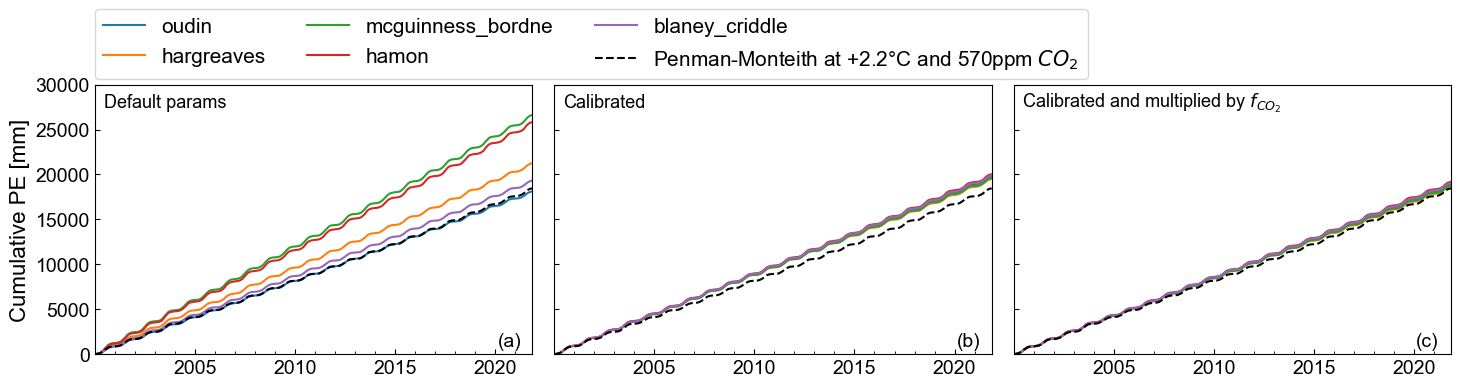

In [31]:
figw_1c = 8.5  # maximum width for 1 column
figw_2c = 17.5  # maximum width for 2 columns
cm1 = 1 / 2.54  # centimeters in inches
vmax = 3.3
vmin = 1.5
day = 120
fig, axs = plt.subplots(ncols=3, figsize=(figw_2c,3.5))

pe_df_def.cumsum().plot(ax=axs[0], legend=False)
pe_df_cali.cumsum().plot(ax=axs[1], legend=False)
pe_df_45.cumsum().plot(ax=axs[2], legend=False)
for i in (1,2):
    axs[i].set_yticklabels("")
for i in (0,1,2):
    axs[i].set_ylim(0, 30000)
    pe_rcp45.cumsum().plot(ax=axs[i], color="k", linestyle="--", label="Penman-Monteith at +2.2°C and 570ppm $CO_2$")
    axs[i].set_xticks(pd.DatetimeIndex(["2005-1-1", "2010-1-1", "2015-1-1", "2020-1-1"]))
    axs[i].set_xlabel("")
axs[0].set_ylabel("Cumulative PE [mm]")
plt.subplots_adjust(wspace=0.05)
axs[0].text(0.02,0.915, "Default params", transform=axs[0].transAxes, fontsize=13)
axs[1].text(0.02,0.915, "Calibrated", transform=axs[1].transAxes, fontsize=13)
axs[2].text(0.02,0.915, r"Calibrated and multiplied by $f_{CO_2}$", transform=axs[2].transAxes, fontsize=13)

axs[0].text(0.92,0.03, "(a)", transform=axs[0].transAxes, fontsize=14)
axs[1].text(0.92,0.03, "(b)", transform=axs[1].transAxes, fontsize=14)
axs[2].text(0.92,0.03, "(c)", transform=axs[2].transAxes, fontsize=14)
axs[0].legend(loc=(-0,1.02), ncol=3, bbox_transform=axs[0].transAxes)
#fig.savefig("figure5.png", dpi=600, bbox_inches="tight")

# Code example in paper

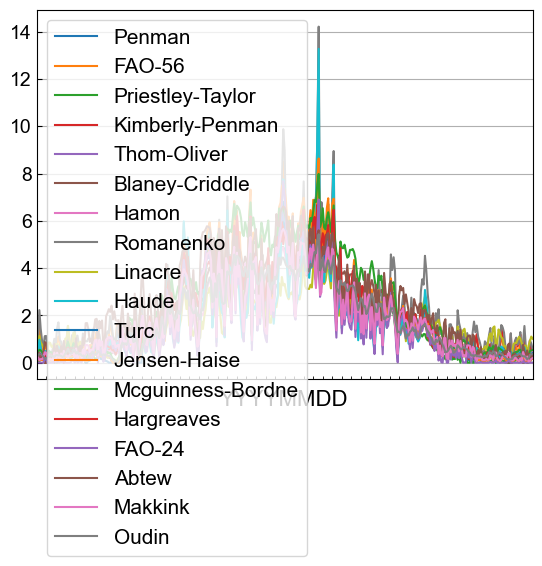

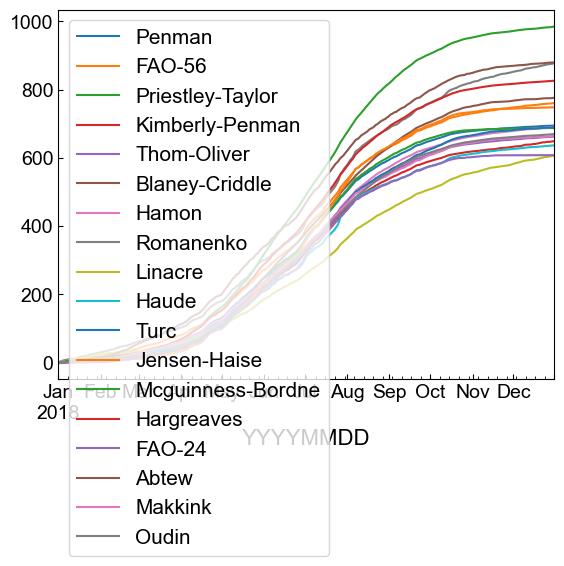

In [32]:
# 1. Import needed Python packages
import numpy as np
import pandas as pd

# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elev = 4  # define elevation [meters above sea-level]

# 4. Estimate PET (all methods) and save the results in a Pandas.DataFrame
pet_df = pyet.calculate_all(tmean, wind, rs, elev, lat, tmax, tmin, rh)
                           
# (4. Estimate potential evaporation - Example with one method)
pyet_makkink = pyet.makkink(tmean, rs, elevation=elev)

# 5. Plot PET 
pet_df.plot()  # daily PET [mm/day]
pet_df.boxplot()  # boxplot PET[mm/day]
pet_df.cumsum().plot()  # cummulative PET [mm]
plt.scatter(pyet_makkink, pet_knmi)  # plot Makkink pyet vs KNMI

In [33]:
# 2. Reading meteorological data
meteo = pd.read_csv("data//example_0//0_example_meteo.csv", index_col=0, parse_dates=True)

In [34]:
# 3. Determining the necessary input data
tmean, tmax, tmin, rh, rs, wind, pet_knmi = (meteo[col] for col in meteo.columns)
lat = 0.91  # define latitude [radians]
elevation = 4  # define elevation [meters above sea-level]

Now that we have defined the input data, we can estimate potential evaporation with different estimation methods. 

In [35]:
# 4. Estimate potential evaporation (with all available methods) and save the results in a Pandas.DataFrame
pet_df  = pyet.calculate_all(tmean, wind, rs, elevation, lat, tmax, tmin, rh)

In [36]:
# 4. Estimate PE and save the results in a xarray.DataArray
pe_pm_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, 
                            lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_makkink = pyet.makkink(tmean, rs, elevation=elevation)
pe_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=elevation, 
                              lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_hamon = pyet.hamon(tmean, lat=lat) 
pe_blaney_criddle = pyet.blaney_criddle(tmean, lat)
pe_hargreaves = pyet.hargreaves(tmean, tmax, tmin, lat=lat)